mobilenet using 100 apoch only achieve 0.6 and 0.5 accuracy


In [68]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB1
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomZoom, RandomContrast, RandomBrightness
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization,GlobalAveragePooling2D, Activation, AveragePooling2D
import numpy as np
import os
import shutil
import random
import cv2
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

In [44]:
import os
from PIL import Image

# Select an image from the training dataset
train_image_path = os.path.join("dataset/train/Level_0", os.listdir("dataset/train/Level_0")[2]) 

# Open the image and get its size
with Image.open(train_image_path) as img:
    width, height = img.size
    print(f"📏 Image Size: {width}x{height}")

📏 Image Size: 500x555


Image shape: (128, 128, 3)


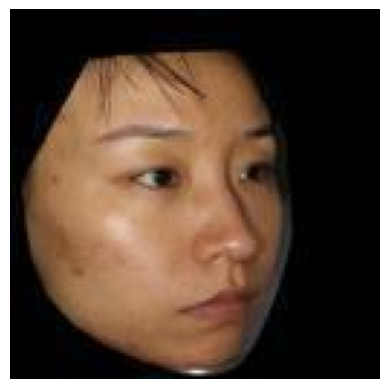

In [45]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
# Define the dataset path
dataset_path = "dataset/train/Level_0"  # Change to an actual dataset directory

# Get a list of image files
image_files = [f for f in os.listdir(dataset_path) if f.endswith(('.png', '.jpg', '.jpeg'))]

# Select the first image
if image_files:
    image_path = os.path.join(dataset_path, image_files[0])

    # Read and display the image
    img = cv2.imread(image_path)  # OpenCV loads images in BGR format
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    print(f"Image shape: {img.shape}")  # Should print (128, 128, 3)

    plt.imshow(img)
    plt.axis("off")  # Hide axis
    plt.show()
else:
    print("No images found in the dataset folder.")

In [55]:
# Define paths
train_dir = "dataset/train"
test_dir = "dataset/test"
image_size=(225,225)
batch_size = 32

def preprocess_image(img):
    """ Resize the image to (128,128) without altering other properties """
    img = np.array(img, dtype=np.float32)  # Ensure float32
    img = cv2.resize(img, image_size, interpolation=cv2.INTER_CUBIC)  # High-quality resizing
    return img  # Return unchanged, only resized image

# Define ImageDataGenerator (without additional augmentation)
train_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

test_datagen = ImageDataGenerator(preprocessing_function=preprocess_image)

# Load images from directories
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size, 
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='categorical'
)

# Get class labels 
class_labels = list(train_data.class_indices.keys())
print("Class labels:", class_labels)


Found 798 images belonging to 3 classes.
Found 202 images belonging to 3 classes.
Class labels: ['Level_0', 'Level_1', 'Level_2']


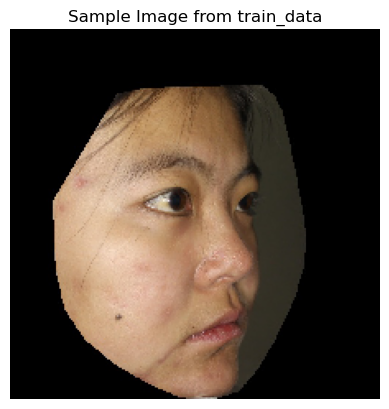

In [56]:
import matplotlib.pyplot as plt

# Get a batch of images and labels
batch_images, batch_labels = next(train_data)

# Select the first image in the batch
sample_image = batch_images[0]

# Display the image
plt.imshow(sample_image.astype("uint8"))  # Convert float32 to uint8 for display
plt.axis("off")  # Hide axis
plt.title("Sample Image from train_data")
plt.show()


In [57]:
import matplotlib.pyplot as plt
import numpy as np

# Get one batch of images and labels from train_data
images, labels = next(iter(train_data))  

# Print shape to verify
print(f"Batch Image Shape: {images.shape}")  # Expected: (batch_size, 128, 128, 3)
print(f"Labels Shape: {labels.shape}")  # Expected: (batch_size, number_of_classes)


Batch Image Shape: (32, 225, 225, 3)
Labels Shape: (32, 3)


In [63]:
data_augmentation = Sequential([
    RandomFlip("horizontal"),
    RandomRotation(0.2),
    RandomZoom(0.2),
    RandomContrast(0.2),
    RandomBrightness(0.2)
])


In [85]:
model = Sequential([
    data_augmentation,

    Conv2D(32, (3,3), padding='same', kernel_regularizer=l2(0.0005), input_shape=(225,225, 3)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Conv2D(64, (3,3), padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    Conv2D(128, (3,3), padding='same', kernel_regularizer=l2(0.0001)),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2,2)),

    AveragePooling2D((2,2)),  # Additional pooling before global pooling
    GlobalAveragePooling2D(),
    
    Dropout(0.6),
    Dense(128, activation='relu', kernel_regularizer=l2(0.0001)),  # Increased neurons
    BatchNormalization(),
    Dropout(0.3),
    
    Dense(3, activation='softmax')  # 3-class classification
])

# Compile the model

optimizer = Adam(learning_rate=0.010)  # Start with 0.001
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
model.build((None, 225,225, 3))

# Model summary
model.summary()

C:\Users\yongs\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_25"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_23 (Sequential)      │ (None, 225, 225, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_66 (Conv2D)              │ (None, 225, 225, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_83          │ (None, 225, 225, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_65 (Activation)      │ (None, 225, 225, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_65 (MaxPooling2D) │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_67 (Conv2D)              │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_84          │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_66 (Activation)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_66 (MaxPooling2D) │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_68 (Conv2D)              │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_85          │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_67 (Activation)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_67 (MaxPooling2D) │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ average_pooling2d_10            │ (None, 14, 14, 128)    │             0 │
│ (AveragePooling2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_25     │ (None, 128)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_46 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_52 (Dense)                │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_86          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_47 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_53 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,555 (435.76 KB)

 Trainable params: 110,851 (433.01 KB)

 Non-trainable params: 704 (2.75 KB)

In [86]:
from sklearn.utils.class_weight import compute_class_weight

# Extract class labels from train_data
y_true = train_data.classes  # Get true labels of training data

# Compute class weights
#class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_true), y=y_true)
#class_weights_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model with class weights
#history = model.fit(train_data, validation_data=test_data, epochs=20, class_weight=class_weights_dict)


history = model.fit(train_data, validation_data=test_data, epochs=20)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 39s 1s/step - accuracy: 0.3193 - loss: 1.6827 - val_accuracy: 0.4703 - val_loss: 13.2214
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4180 - loss: 1.2355 - val_accuracy: 0.3911 - val_loss: 1.7748
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4298 - loss: 1.1335 - val_accuracy: 0.3911 - val_loss: 2.5479
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4676 - loss: 1.1027 - val_accuracy: 0.4010 - val_loss: 2.1494
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4870 - loss: 1.1073 - val_accuracy: 0.4703 - val_loss: 1.0807
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - accuracy: 0.4706 - loss: 1.0974 - val_accuracy: 0.3960 - val_loss: 1.0953
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4605 - loss: 1.0864 - val_accuracy: 0.4455 - val_loss: 1.0605
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 34s 1s/step - accuracy: 0.4283 - loss: 1.1012 - val_accuracy: 0.3911 - val_loss

In [81]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

# Load Pre-trained MobileNetV2 (without top layers)
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(225, 225, 3))

# Freeze the base model layers
base_model.trainable = False  

# Add Custom Classification Layers
x = base_model.output
x = GlobalAveragePooling2D()(x)  # Flatten output
x = Dense(128, activation='relu')(x)  # Fully connected layer
x = Dense(64, activation='relu')(x)   # Another FC layer
output_layer = Dense(3, activation='softmax')(x)  # Final classification layer

# Define Model
model = Model(inputs=base_model.input, outputs=output_layer)

# Compile Model
optimizer = Adam(learning_rate=0.001)
# Compile Model
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Model Summary
model.summary()


C:\Users\yongs\AppData\Local\Temp\ipykernel_16548\4008047942.py:7: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(225, 225, 3))


Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, 225, 225,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 113, 113,  │        864 │ input_layer_16[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 113, 113,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 113, 113,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 113, 113,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 113, 113,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 113, 113,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 113, 113,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 113, 113,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 113, 113,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 115, 115,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 57, 57,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 57, 57,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 57, 57,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 57, 57,    │      2,304 │ block_1_depthwis

 Total params: 2,430,403 (9.27 MB)

 Trainable params: 172,419 (673.51 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [82]:
# Learning Rate Adjustment
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=0.00001)

# Train Model
history = model.fit(train_data, validation_data=test_data, epochs=30, callbacks=[reduce_lr])

Epoch 1/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 21s 700ms/step - accuracy: 0.4246 - loss: 1.0648 - val_accuracy: 0.4703 - val_loss: 1.0218 - learning_rate: 0.0010
Epoch 2/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 644ms/step - accuracy: 0.4565 - loss: 1.0029 - val_accuracy: 0.4554 - val_loss: 0.9944 - learning_rate: 0.0010
Epoch 3/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 651ms/step - accuracy: 0.5135 - loss: 0.9456 - val_accuracy: 0.3812 - val_loss: 1.0260 - learning_rate: 0.0010
Epoch 4/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 645ms/step - accuracy: 0.5262 - loss: 0.9439 - val_accuracy: 0.3960 - val_loss: 1.0276 - learning_rate: 0.0010
Epoch 5/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 17s 661ms/step - accuracy: 0.5398 - loss: 0.8812 - val_accuracy: 0.4802 - val_loss: 1.0030 - learning_rate: 0.0010
Epoch 6/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 654ms/step - accuracy: 0.5787 - loss: 0.9037 - val_accuracy: 0.4802 - val_loss: 0.9767 - learning_rate: 5.0000e-04
Epoch 7/30
25/25 ━━━━━━━━━━━━━━━━━━━━ 16s 653ms/step - accuracy: 0.6060 - loss

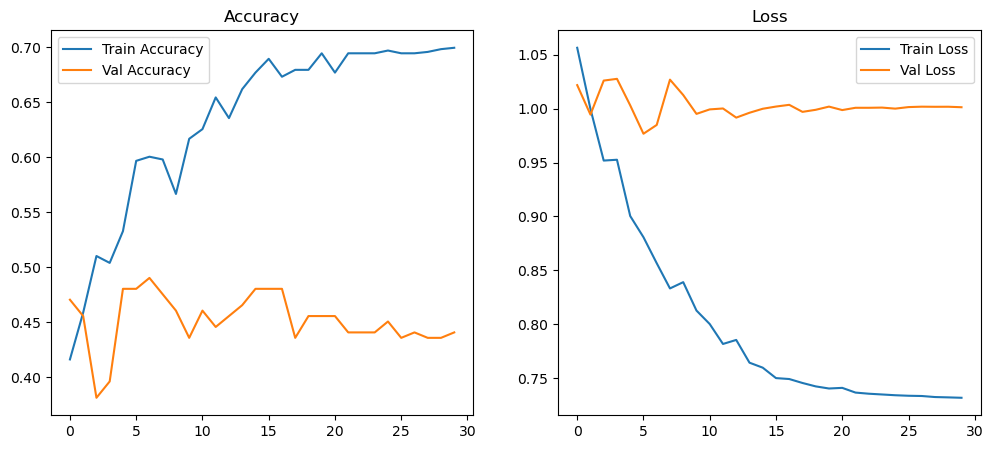

In [83]:
import matplotlib.pyplot as plt

# Plot accuracy and loss
def plot_history(history):
    plt.figure(figsize=(12,5))

    # Accuracy plot
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.legend()
    plt.title("Accuracy")

    # Loss plot
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.legend()
    plt.title("Loss")
 
    plt.show()

plot_history(history)

In [10]:
test_loss, test_acc = model.evaluate(test_data)
print(f"✅ Test Accuracy: {test_acc * 100:.2f}%")


7/7 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - accuracy: 0.4205 - loss: 1.0786
✅ Test Accuracy: 39.30%


7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 589ms/step


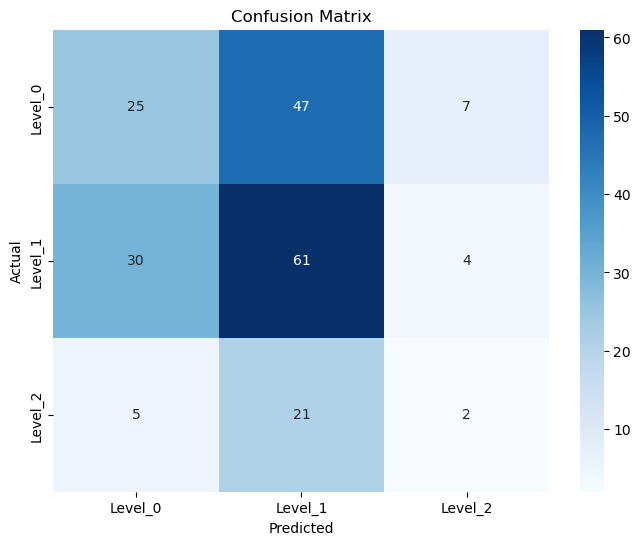

              precision    recall  f1-score   support

     Level_0       0.42      0.32      0.36        79
     Level_1       0.47      0.64      0.54        95
     Level_2       0.15      0.07      0.10        28

    accuracy                           0.44       202
   macro avg       0.35      0.34      0.33       202
weighted avg       0.41      0.44      0.41       202



In [84]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Get true labels and predictions
y_true = test_data.classes
y_pred = np.argmax(model.predict(test_data), axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Classification report
print(classification_report(y_true, y_pred, target_names=class_labels))


In [12]:
#Image prediction

# Load and preprocess an image
img_path = "dataset/test/Level_0/Levle0_15.jpg"  # Change to an actual test image path
img = image.load_img(img_path, target_size=(128, 128))
img_array = image.img_to_array(img) / 255.0
img_array = np.expand_dims(img_array, axis=0)

# Make prediction
prediction = model.predict(img_array)
predicted_class = class_labels[np.argmax(prediction)]
print(f"🔍 Predicted Acne Level: {predicted_class}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
🔍 Predicted Acne Level: Level_0


In [ ]:
model.save("acne_classification_model.h5")
print("✅ Model saved successfully!")
